## This notebook is for plotting CVs of trajectories and visualization with chemiscope

In [67]:
import chemiscope
import torch 
import numpy as np
import os
from typing import Dict, List, Optional
from scipy.stats import moment
from metatensor.torch import Labels, TensorBlock, TensorMap
from metatomic.torch import (
    AtomisticModel,
    ModelCapabilities,
    ModelEvaluationOptions,
    ModelMetadata,
    ModelOutput,
    System,
    systems_to_torch,
    load_atomistic_model
)
from featomic.torch import SoapPowerSpectrum
import vesin
from ase.io import read
import matplotlib.pyplot as plt

In [53]:
cwd = '/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/metad/test'
model_name = 'soap_wrapper_zmin25.0_zmax35.0.pt'
model_name = '/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/results/amorph-metad-1ps/v0/SOAP/866/all/PCAfull/interval_1/lag_0/sigma_0/ridge_a1e-05/SOAP_866_[8]/model_soap.pt'
trj_name = 'positions.lammpstrj'

In [54]:
# Load model
CVmodel = load_atomistic_model(os.path.join(cwd, model_name), extensions_directory='.')


[W206 17:58:34.239802000 model.cpp:232] Warning: 'features' defines 2 output variants and 'features' has an empty description. Consider adding meaningful descriptions helping users to distinguish between them. (function set_outputs)
[W206 17:58:34.239816000 model.cpp:232] Warning: 'features' defines 2 output variants and 'features/per_atom' has an empty description. Consider adding meaningful descriptions helping users to distinguish between them. (function set_outputs)


#### Load trajectory for testing

In [55]:
structures = read('/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/data/icemeltinterface/nobias/short.lammpstrj', index=':')
structures = structures[:10]

# Adjust trj:

In [56]:
systems = systems_to_torch(structures, dtype=torch.float64)

systems_new = []
for i, system in enumerate(systems):
    
    #atoms = structures[i]
    nlistoptions = CVmodel.requested_neighbor_lists()[0]
    print(nlistoptions)
    nlist = vesin.NeighborList(cutoff=nlistoptions.cutoff, full_list=nlistoptions.full_list) 
    i, j, S, D = nlist.compute(
        points=system.positions,
        box=system.cell, 
        periodic=True,
        quantities="ijSD"
    )
    #i, j, S, D = ase_neighbor_list(quantities="ijSD", a=atoms, cutoff=4.5)
    i = torch.from_numpy(i.astype(int))
    j = torch.from_numpy(j.astype(int))
    neighbor_indices = torch.stack([i, j], dim=1)
    neighbor_shifts = torch.from_numpy(S.astype(int))

    sample_values = torch.hstack([neighbor_indices, neighbor_shifts])
    samples = Labels(
        names=[
            "first_atom",
            "second_atom",
            "cell_shift_a",
            "cell_shift_b",
            "cell_shift_c",
        ],
        values=sample_values,
    )

    neighbors = TensorBlock(
        values=torch.from_numpy(D).reshape(-1, 3, 1),
        samples=samples,
        components=[Labels.range("xyz", 3)],
        properties=Labels.range("distance", 1),
    )
    system.add_neighbor_list(nlistoptions, neighbors)
    systems_new.append(system)
systems = systems_new

NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)
NeighborListOptions(cutoff=8.000000, full_list=False, strict=False)


#### Get CV values

In [57]:
selected_atoms = Labels(
        names=["system", "atom"],
        values=torch.tensor([[0, j] for j in np.arange(0, len(structures[0]), 3)], dtype=torch.int32),)
    

eval_options = ModelEvaluationOptions(
            length_unit='',
            outputs={"features": ModelOutput(per_atom=False), 
                     "features/per_atom": ModelOutput(per_atom=True)},
            selected_atoms=selected_atoms,
        )
CVs = []
CVs_per_atom = []
for system in systems:
    cv = CVmodel(
        systems=[system],
        options=eval_options,
        check_consistency=True,
    )
    CVs.append(cv['features'].block().values)
    CVs_per_atom.append(cv['features/per_atom'].block().values)

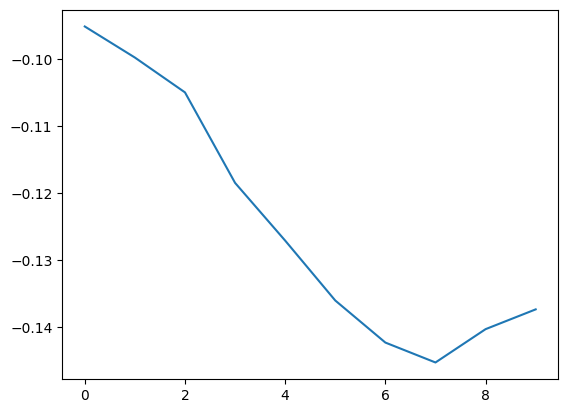

In [68]:
CVperatom = torch.stack(CVs_per_atom, dim=0).squeeze().numpy()
CV = torch.stack(CVs, dim=0).squeeze().numpy()
plt.plot(CV)



In [ ]:
io = structures[0].get_atomic_numbers() == 8
time=[]
#for atoms in traj:
#    time.append(atoms.info['timestep'])
time = np.arange(0, len(structures))*1.0  # 1ps interval
cs = chemiscope.show(
    structures, 
    properties={
        'time': time,
        #'o_cv': {"values": CVperatomtensor.flatten(), "target": "atom"},
        'cv': {"values": CVtensor, "target": "structure"},},
    #mode="structure",
    settings=chemiscope.quick_settings(trajectory=True, structure_settings={"unitCell":True,
             'environments': {'activated': True}, 'map': {'color': {'property': 'o_cv'}}, 'color': {'property': 'o_cv', 'min': -0.1,
                              'max': 0.1, 'transform': 'linear','palette': 'bwr'} }),
    environments=[(j,i,3.5) for j in range(len(structures)) for i in io]
)
cs

Exception: wrong size for the property 'o_cv' with target=='atom': expected 17370 values, got 5790